In [618]:
def txt_dict(filename):
    #test loading the file, printing sample contents
    with open(filename,'r') as fp:
        temp = ujson.load(fp);
    #print '# elements: ', len(temp1)
    #print 'sample of contents:'
    #print repr(temp1[1]).decode("unicode-escape")
    return temp

In [619]:
def collapse_data(data):
    
    users = {}
    
    
    for item in data:
        
        user = users.get(item['userName'], None)
        
        if user != None:
       
            user['groupName'].add(item['groupName'])    
            if item['imageName'] is not None:
         
        
                user['image'].add( (item['imageName'],item['imageHeight'],item['imageWidth'],item['imageType'],item['imageSize']))
    
            fieldName = item.get('userProfileFieldName', None)
            
            if fieldName is not None:
            
                user[fieldName] = item['userProfileFieldValue']
    
    
        else:
        
            user = item['userName']
        
            users[user] = {}
        
            users[user]['groupName'] = set([item['groupName']])
            
            users[user]['registrationTime']= item['registrationTime']
            
            if item['imageName'] is not None:
            
            
                users[user]['image']= set( [(item['imageName'],item['imageHeight'],item['imageWidth'],item['imageType'],item['imageSize'])] ) 
                
                
            else:
                
                users[user]['image'] =set([])
        
    return users

In [620]:
users = collapse_data(txt_dict("data/usersAFiltered.txt"))

In [621]:
posts =  txt_dict("data/postsAFiltered.txt")

In [622]:
def usr_bow(posts):
    
    posts_bow = {}
    
    for post in posts:
    
        if posts_bow.get(post['userName'], None) == None:
            
            posts_bow[post['userName']] = {}
            
            posts_bow[post['userName']]['body'] = [post['postBody']  ]
            
            posts_bow[post['userName']]['subject'] = [post['postSubject']  ]
            
            posts_bow[post['userName']]['title'] = [post['threadTitle']  ]


            
        else:
            
            posts_bow[post['userName']]['body'] = posts_bow[post['userName']]['body']  + [post['postBody']]
            
            posts_bow[post['userName']]['subject'] = posts_bow[post['userName']]['subject'] +[post['postSubject']  ]

            posts_bow[post['userName']]['title'] = posts_bow[post['userName']]['title'] + [post['threadTitle']  ]
            
            
    return posts_bow


In [37]:
posts = usr_bow(posts)

In [ ]:
def gen_features():
    
    
    X = []
    
    Y = []
    
    
    
    return X, Y 

In [624]:
def check_exist(usrA, usrB, usrsA, usrsB, postsA, postsB, ):
    
    
    if usrA not in usrsA.keys():
        
        return 0
    
    if usrB not in usrsB.keys():
        
        return 0
    
    if usrA not in postsA.keys():
        
        return 0
    
    if usrB not in postsB.keys():
        
        return 0
    
    return 1


def gen_pos_pairs(filename,  postsA, postsB, usrsA, usrsB):

    import ujson
    import ftfy

    with open(filename, 'rb') as f:
        data = f.readlines()

    data = map(lambda x: x.rstrip(), data)

    # convert to array of JSON objects
    data_json_str = "[" + ','.join(data) + "]"

    # load it
    data_gt = ujson.loads(data_json_str)

    X = []
    
    for pair in data_gt:
        
        if pair['class'] == 1:
            
            usr1 = pair['site_a']
            
            usr2 = pair['site_b']
            
           # if not check_exist(usr1, usr2, usrsA, usrsB, postsA, postsB):
                
            #    continue
            
            
            if usr2 == u'Ghost\u2122':
                
                usr2 = "GhostTM"
                
            if usr2 == u'nicklan&lt;b&gt;&lt;/b&gt;':
                
                usr2 = u'nicklan<b></b>'
            
            X.append(featurise(usr1, usr2,  postsA, postsB, usrsA, usrsB))
            
            
    return X


def gen_neg_pairs(filename, postsA, postsB, usrsA, usrsB):
    
    import ujson
    import ftfy
    
    import random

    with open(filename, 'rb') as f:
        data = f.readlines()

    data = map(lambda x: x.rstrip(), data)

    # convert to array of JSON objects
    data_json_str = "[" + ','.join(data) + "]"

    # load it
    data_gt = ujson.loads(data_json_str)

    X = []
    
    pos = []
    
    for pair in data_gt:
        
        if pair['class'] == 1:
            
            pos.append((pair['site_a'],pair['site_b']))
            
    for i in range(4*len(data_gt)):
        
        
        usr1 = random.choice(usrsA.keys())
        
        usr2 = random.choice(usrsB.keys())
        
        if (usr1, usr2) not in pos:
        
        
            X.append(featurise(usr1, usr2,  postsA, postsB, usrsA, usrsB))

            
    return X


In [625]:
def text_to_vector(text):
    
    from collections import Counter
    return Counter(text)


def get_cosine(vec1, vec2):
    
    import math
    
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator




In [626]:
def indi_scores(l1, l2):
    
    import numpy as np
    
    l1_t = []
    
    l2_t = []
    
    
    for item in l1:
        
        l1_t.append(set(item.lower().split()))
    
    for item in l2:
        
        l2_t.append(set(item.lower().split()))

    l1 = l1_t
    
    l2 = l2_t
        
    
    scores_jac = []
    
    scores_cs = []
    
    
    for item in l1:
        
        for item2 in l2:
            
            if len(item|item2) == 0:
                scores_jac.append(0)
            else:
                scores_jac.append(  float(len(item&item2))/float((len(item|item2))) )   
    
            vec1 = text_to_vector(item)
            vec2 = text_to_vector(item2)
    
            scores_cs.append(get_cosine(vec1, vec2))
    
    cs_feats = [ min(scores_cs), max(scores_cs), np.mean(scores_cs)     ]
    
    
    
    jac_feats = [ min(scores_jac), max(scores_jac), np.mean(scores_cs)]
    
    return cs_feats + jac_feats    
    
def overall_scores(l1, l2):
    
    
    vec = []
    
    item = set()
    
    item2 = set()
    
    for it in l1:
        
        item |= set(it.lower().split())
        
    for it in l2:
    
        item2 |= set(it.lower().split())
        
    
    
    if len(item|item2) == 0:
            
        vec.append(0)
        
    else:
        vec.append(  float(len(item&item2))/float((len(item|item2))) )   

    vec1 = text_to_vector(item)
    vec2 = text_to_vector(item2)
    
    vec.append(get_cosine(vec1, vec2))
        
    return vec

        
def featurise( usr1, usr2, postsA, postsB, usrA, usrB  ):
    
    import editdistance
    
    
    vector = []
    
    
    #feature1 : editDist between usernames
    
    
    username1 = usr1
    
    username2 = usr2
    
    ft1 = editdistance.eval(usr1, usr2)

    vector.append(int(ft1))
    
    
    #feature2 : editDist between lowercase usernames
    
    ft2 = editdistance.eval(usr1.lower(), usr2.lower())
    
    vector.append(int(ft2))
    
    
    #feature3 : timediff between user     
    
    ft3 =  abs(usrsA[usr1]['registrationTime'] - usrsB[usr2]['registrationTime'])
    
    vector.append(int(ft3))
    
    #feature4: TimeZone
    
    if usrsA[usr1]['Time Zone'] == usrsB[usr2]['Time Zone']:
    
        ft4 = 1
        
    else:
        
        ft4 = 0
    
    vector.append(ft4)
  
    #text Features
    
    #feature 5: Textual, Individual, overall
    
    if (postsA.get(usr1, None) != None) and (postsB.get(usr2, None) != None):
    
    
        ft5 = indi_scores(postsA[usr1]['body'],postsB[usr2]['body'])

        ft5 = ft5 + indi_scores(postsA[usr1]['subject'],postsB[usr2]['subject'])

        ft5 = ft5 + indi_scores(postsA[usr1]['title'],postsB[usr2]['title'])

        vector += ft5    
        
        
                
        ft6 = overall_scores(postsA[usr1]['body'],postsB[usr2]['body'])

        ft6 = ft6 + overall_scores(postsA[usr1]['subject'],postsB[usr2]['subject'])

        ft6 = ft6 + overall_scores(postsA[usr1]['title'],postsB[usr2]['title'])

        vector += ft6 
                
    else:
        
        vector += [-1 for i in range(18)]
        
        vector +=[-1 for i in range(6)]
    
    #feature7: Group Affliations
    
    groups1 = usrsA[usr1]
    
    groups2 = usrsB[usr2]
    
    n = 0
    
    for item in groups1:
        
        for item2 in groups2:

            if item[:3].lower() == item2[:3].lower():
                
                n+=1
                
    ft7 = n
    
    vector.append(ft7)

    return vector
    
    
    

In [627]:
usrsA = collapse_data(txt_dict("data/usersAFiltered.txt"))
usrsB = collapse_data(txt_dict("data/usersBFiltered.txt"))
postsA = usr_bow(txt_dict("data/postsAFiltered.txt"))
postsB = usr_bow(txt_dict("data/postsBFiltered.txt"))

In [628]:
def check_feat(key, d):
    
    for item in d:
        
        if key not in d[item].keys():
            return "Not There", item
    
    
    return "there in every element! :)"
    

In [539]:
X_pos = gen_pos_pairs("data/16_9_matches_j.txt", postsA, postsB, usrsA, usrsB) 
Y_pos = [1 for i in X_pos]
X_neg = gen_neg_pairs("data/16_9_matches_j.txt", postsA, postsB, usrsA, usrsB)
Y_neg = [0 for i in X_neg]

X = X_pos + X_neg
Y = Y_pos + Y_neg



In [540]:
import numpy as np

X = np.asarray(X)

In [541]:
from sklearn.utils import shuffle

X, Y= shuffle(X, Y)

In [542]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

classifier = RandomForestClassifier()
cv = 5
scores = cross_val_score(classifier, X[:, :], Y, cv=cv)

In [545]:
tot = 0
for score in  scores:
    tot += score
    
print tot/cv

0.922586699923


# ROC CURVE

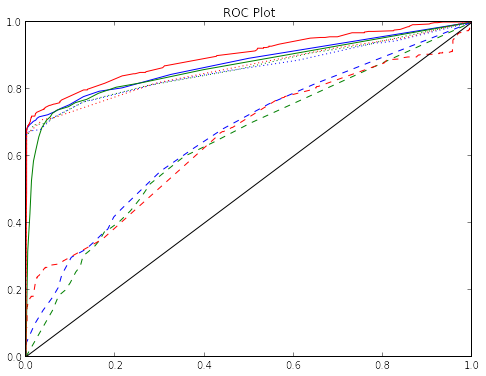

In [562]:
%matplotlib inline
from sklearn import metrics
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import ExtraTreesClassifier

from sklearn.ensemble import AdaBoostClassifier

import matplotlib.lines as mlines

plt.figure(figsize=(8,6))

X = np.asarray(X)
Y = np.asarray(Y)

Xt = X[:, 2:]

classifier = RandomForestClassifier(n_estimators=20, n_jobs=10)

classifier.fit(Xt[:300 , :], Y[ :300])
scores = classifier.predict_proba(Xt[ 300:, :])
fpr, tpr, threshold = metrics.roc_curve(Y[300:], scores[:, 1:])


plt.plot(fpr, tpr, ls='--')

classifier = ExtraTreesClassifier(n_estimators=20, n_jobs=10)

X = np.asarray(X)
Y = np.asarray(Y)

classifier.fit(Xt[:300 , :], Y[ :300])
scores = classifier.predict_proba(Xt[ 300:, :])
fpr, tpr, threshold = metrics.roc_curve(Y[300:], scores[:, 1:])


plt.plot(fpr, tpr, ls ='--')

classifier = AdaBoostClassifier(n_estimators=20)

X = np.asarray(X)
Y = np.asarray(Y)

classifier.fit(Xt[:300 , :], Y[ :300])
scores = classifier.predict_proba(Xt[ 300:, :])
fpr, tpr, threshold = metrics.roc_curve(Y[300:], scores[:, 1:])


plt.plot(fpr, tpr, ls ='--')



Xt = X[:, :]

classifier = RandomForestClassifier(n_estimators=20, n_jobs=10)


classifier.fit(Xt[:300 , :], Y[ :300])
scores = classifier.predict_proba(Xt[ 300:, :])
fpr, tpr, threshold = metrics.roc_curve(Y[300:], scores[:, 1:])


plt.plot(fpr, tpr, color='b' )

classifier = ExtraTreesClassifier(n_estimators=20, n_jobs=10)


classifier.fit(Xt[:300 , :], Y[ :300])
scores = classifier.predict_proba(Xt[ 300:, :])
fpr, tpr, threshold = metrics.roc_curve(Y[300:], scores[:, 1:])


plt.plot(fpr, tpr,color='g' )

classifier = AdaBoostClassifier(n_estimators=20)



classifier.fit(Xt[:300 , :], Y[ :300])
scores = classifier.predict_proba(Xt[ 300:, :])
fpr, tpr, threshold = metrics.roc_curve(Y[300:], scores[:, 1:])


plt.plot(fpr, tpr,color='r',  )


Xt = X[:, :2]

classifier = RandomForestClassifier(n_estimators=20, n_jobs=10)


classifier.fit(Xt[:300 , :], Y[ :300])
scores = classifier.predict_proba(Xt[ 300:, :])
fpr, tpr, threshold = metrics.roc_curve(Y[300:], scores[:, 1:])


blue_line, = plt.plot(fpr, tpr, color='b' , ls =':' )

classifier = ExtraTreesClassifier(n_estimators=20, n_jobs=10)



classifier.fit(Xt[:300 , :], Y[ :300])
scores = classifier.predict_proba(Xt[ 300:, :])
fpr, tpr, threshold = metrics.roc_curve(Y[300:], scores[:, 1:])


plt.plot(fpr, tpr,color='g' ,ls =':')

classifier = AdaBoostClassifier(n_estimators=20)


classifier.fit(Xt[:300 , :], Y[ :300])
scores = classifier.predict_proba(Xt[ 300:, :])
fpr, tpr, threshold = metrics.roc_curve(Y[300:], scores[:, 1:])


plt.plot(fpr, tpr,color='r', ls=':' )

plt.legend(handles=[blue_line], loc='best')
plt.title("ROC Plot")

plt.plot([0,1], [0,1], color='black'  )

plt.show()


# PR Curve

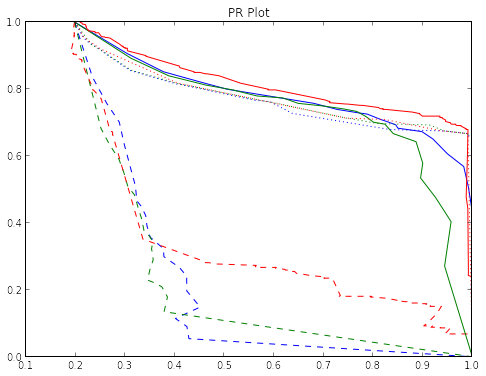

In [565]:
%matplotlib inline
from sklearn import metrics
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import ExtraTreesClassifier

from sklearn.ensemble import AdaBoostClassifier

import matplotlib.lines as mlines

plt.figure(figsize=(8,6))

X = np.asarray(X)
Y = np.asarray(Y)

Xt = X[:, 2:]

classifier = RandomForestClassifier(n_estimators=20, n_jobs=10)

classifier.fit(Xt[:300 , :], Y[ :300])
scores = classifier.predict_proba(Xt[ 300:, :])
fpr, tpr, threshold = metrics.precision_recall_curve(Y[300:], scores[:, 1:])


plt.plot(fpr, tpr, ls='--')

classifier = ExtraTreesClassifier(n_estimators=20, n_jobs=10)

X = np.asarray(X)
Y = np.asarray(Y)

classifier.fit(Xt[:300 , :], Y[ :300])
scores = classifier.predict_proba(Xt[ 300:, :])
fpr, tpr, threshold = metrics.precision_recall_curve(Y[300:], scores[:, 1:])


plt.plot(fpr, tpr, ls ='--')

classifier = AdaBoostClassifier(n_estimators=20)

X = np.asarray(X)
Y = np.asarray(Y)

classifier.fit(Xt[:300 , :], Y[ :300])
scores = classifier.predict_proba(Xt[ 300:, :])
fpr, tpr, threshold = metrics.precision_recall_curve(Y[300:], scores[:, 1:])


plt.plot(fpr, tpr, ls ='--')



Xt = X[:, :]

classifier = RandomForestClassifier(n_estimators=20, n_jobs=10)


classifier.fit(Xt[:300 , :], Y[ :300])
scores = classifier.predict_proba(Xt[ 300:, :])
fpr, tpr, threshold = metrics.precision_recall_curve(Y[300:], scores[:, 1:])


plt.plot(fpr, tpr, color='b' )

classifier = ExtraTreesClassifier(n_estimators=20, n_jobs=10)


classifier.fit(Xt[:300 , :], Y[ :300])
scores = classifier.predict_proba(Xt[ 300:, :])
fpr, tpr, threshold = metrics.precision_recall_curve(Y[300:], scores[:, 1:])


plt.plot(fpr, tpr,color='g' )

classifier = AdaBoostClassifier(n_estimators=20)



classifier.fit(Xt[:300 , :], Y[ :300])
scores = classifier.predict_proba(Xt[ 300:, :])
fpr, tpr, threshold = metrics.precision_recall_curve(Y[300:], scores[:, 1:])


plt.plot(fpr, tpr,color='r',  )


Xt = X[:, :2]

classifier = RandomForestClassifier(n_estimators=20, n_jobs=10)


classifier.fit(Xt[:300 , :], Y[ :300])
scores = classifier.predict_proba(Xt[ 300:, :])
fpr, tpr, threshold = metrics.precision_recall_curve(Y[300:], scores[:, 1:])


blue_line, = plt.plot(fpr, tpr, color='b' , ls =':' )

classifier = ExtraTreesClassifier(n_estimators=20, n_jobs=10)



classifier.fit(Xt[:300 , :], Y[ :300])
scores = classifier.predict_proba(Xt[ 300:, :])
fpr, tpr, threshold = metrics.precision_recall_curve(Y[300:], scores[:, 1:])


plt.plot(fpr, tpr,color='g' ,ls =':')

classifier = AdaBoostClassifier(n_estimators=20)


classifier.fit(Xt[:300 , :], Y[ :300])
scores = classifier.predict_proba(Xt[ 300:, :])
fpr, tpr, threshold = metrics.precision_recall_curve(Y[300:], scores[:, 1:])


plt.plot(fpr, tpr,color='r', ls=':' )

plt.legend(handles=[blue_line], loc='best')
plt.title("PR Plot")


plt.show()
